In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

In [2]:
tf.__version__

'2.0.0'

In [3]:
train_image_path = glob.glob('/Users/mac/PycharmProjects/dc_2000/train/*/*.jpg')
test_image_path = glob.glob('/Users/mac/PycharmProjects/dc_2000/test/*/*.jpg')

In [4]:
len(train_image_path), len(test_image_path)

(2000, 1000)

In [5]:
train_image_path[:5]

['/Users/mac/PycharmProjects/dc_2000/train/cat/cat.952.jpg',
 '/Users/mac/PycharmProjects/dc_2000/train/cat/cat.946.jpg',
 '/Users/mac/PycharmProjects/dc_2000/train/cat/cat.6.jpg',
 '/Users/mac/PycharmProjects/dc_2000/train/cat/cat.749.jpg',
 '/Users/mac/PycharmProjects/dc_2000/train/cat/cat.991.jpg']

In [6]:
p = '/Users/mac/PycharmProjects/dc_2000/train/cat/cat.952.jpg'

In [7]:
int(p.split('/')[-2] == 'cat')

1

In [8]:
train_label = [int(path.split('/')[-2] == 'cat') for path in train_image_path]
test_label = [int(path.split('/')[-2] == 'cat') for path in test_image_path]

In [9]:
train_label[:5], test_label[:5]

([1, 1, 1, 1, 1], [1, 1, 1, 1, 1])

In [10]:
def load_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [360, 360])
    image = tf.image.random_crop(image, [256, 256, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, 0.5)
    image = tf.image.random_contrast(image, 0, 1)
    image = tf.cast(image, tf.float32)
    image = image / 255
    label = tf.reshape(label, [1])
    return image, label

In [11]:
train_label[0]

1

In [12]:
a = tf.reshape(train_label[0], [1])
a.numpy()

array([1], dtype=int32)

In [13]:
train_image_ds = tf.data.Dataset.from_tensor_slices((train_image_path, train_label))
test_image_ds = tf.data.Dataset.from_tensor_slices((test_image_path, test_label))

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [15]:
train_image_ds = train_image_ds.map(load_preprocess_image, num_parallel_calls=AUTOTUNE)
test_image_ds = test_image_ds.map(load_preprocess_image, num_parallel_calls=AUTOTUNE)

In [16]:
train_image_ds, test_image_ds

(<ParallelMapDataset shapes: ((256, 256, 3), (1,)), types: (tf.float32, tf.int32)>,
 <ParallelMapDataset shapes: ((256, 256, 3), (1,)), types: (tf.float32, tf.int32)>)

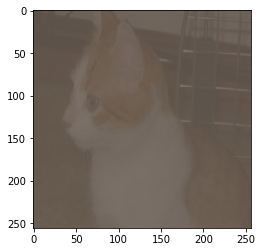

In [26]:
for img, label in train_image_ds.take(1):
    plt.imshow(img)

In [18]:
BATCH_SIZE = 32
train_count = len(train_image_path)
test_count = len(test_image_path)

In [19]:
train_image_ds = train_image_ds.shuffle(train_count).batch(BATCH_SIZE)
train_image_ds = train_image_ds.prefetch(AUTOTUNE)
test_image_ds = test_image_ds.batch(BATCH_SIZE)
test_image_ds = test_image_ds.prefetch(AUTOTUNE)

In [20]:
imgs, labels = next(iter(train_image_ds))

In [21]:
imgs.shape, labels.shape

(TensorShape([32, 256, 256, 3]), TensorShape([32, 1]))

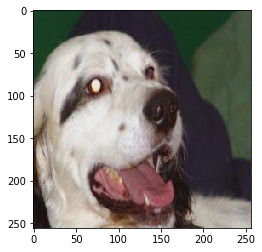

In [22]:
plt.imshow(imgs[0])

In [23]:
labels[0].numpy()

array([0], dtype=int32)

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), input_shape=(256,256,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(1024, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(1024, (3,3), activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 59, 59, 256)       2

In [26]:
pred = model(imgs)

In [27]:
pred.shape

TensorShape([32, 1])

In [28]:
np.array([p[0].numpy() for p in  tf.cast(pred > 0, tf.int32)])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [29]:
np.array([l[0].numpy() for l in labels])

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1], dtype=int32)

In [30]:
ls = tf.keras.losses.BinaryCrossentropy()

In [31]:
ls([0.,1.,0.,1.],[1.,1.,1.,1.])

<tf.Tensor: id=1242, shape=(), dtype=float32, numpy=7.6666193>

In [32]:
ls([[0.],[1.],[0.],[1.]],[[1.],[1.],[1.],[1.]])

<tf.Tensor: id=1283, shape=(), dtype=float32, numpy=7.6666193>

In [33]:
tf.keras.losses.binary_crossentropy([0.,1.,0.,1.],[1.,1.,1.,1.])

<tf.Tensor: id=1307, shape=(), dtype=float32, numpy=7.6666193>

In [34]:
optimizer=tf.keras.optimizers.Adam()

In [35]:
train_loss = tf.keras.metrics.Mean('train_loss')
train_acc = tf.keras.metrics.Accuracy()
test_loss = tf.keras.metrics.Mean('test_loss')
test_acc = tf.keras.metrics.Accuracy()

In [36]:
train_acc([1,0,1],[1,1,1])

<tf.Tensor: id=1376, shape=(), dtype=float32, numpy=0.6666667>

In [37]:
def train_step(model, image, label):
    with tf.GradientTape() as t:
        pred = model(image)
        loss_step = tf.keras.losses.BinaryCrossentropy(from_logits=True)(label, pred)
    grads = t.gradient(loss_step, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(loss_step)
    train_acc(label, tf.cast(pred>0, tf.int32))

In [38]:
def test_step(model, image, label):
    pred = model(image, training=False)
    test_loss_step = tf.keras.losses.BinaryCrossentropy(from_logits=True)(label, pred)
    test_loss(test_loss_step)
    test_acc(label, tf.cast(pred>0, tf.int32))

In [39]:
train_loss_result = []
train_acc_result = []
test_loss_result = []
test_acc_result = []

In [40]:
num_epoch = 5

In [41]:
for epoch in range(num_epoch):
    for imgs_train, labels_train in train_image_ds:
        train_step(model, imgs_train, labels_train)
        print('.', end='')
    print()
    
    train_loss_result.append(train_loss.result())
    train_acc_result.append(train_acc.result())
    
    for imgs_test, labels_test in test_image_ds:
        test_step(model, imgs_test, labels_test)
        
    test_loss_result.append(test_loss.result())
    test_acc_result.append(test_acc.result())
    
    print('Epoch {} : loss is {:.3f}, accuracy is {:.3f}, test_loss is {:.3f}, test_accuracy is {:.3f}'.format(
        epoch + 1, train_loss.result(), train_acc.result(), test_loss.result(), test_acc.result()
    ))
    
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

.

KeyboardInterrupt: 